## ELEC 478, Final project
### Philip Chen
For my final project, I decided to investigate the accuracy of SVM, ANN, and CNN for Google's Quickdraw dataset. The original project features 50 million datapoints and 345 classes, as well as time series information for each drawing, representing stroke order. The original project is known as a fun game where users can draw a picture, and Google will guess what they drew. https://quickdraw.withgoogle.com/data

For the sake of not spending too much compute time and to keep this project "unique" and not based on previous studies (assignment criteria to not do a project on wellknown datasets), I made my own subset from 9 classes of images, downsized to 28x28 and without time series information (where RNN's would be useful). I didn't see many people doing something like this online, so I wanted to see how accurate each method is, especially CNN's.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
classes = {0: "banana", 1: "bat", 2: "bowtie", 3: "camera", 4: "door", 5: "eyeglasses", 6: "hand", 7: "mushroom", 8: "wheel"}

# np_banana = np.load("/Users/philipchen/Downloads/quickdrawsubset/full_numpy_bitmap_banana.npy")
# np_bat = np.load("/Users/philipchen/Downloads/quickdrawsubset/full_numpy_bitmap_bat.npy")
# np_bowtie = np.load("/Users/philipchen/Downloads/quickdrawsubset/full_numpy_bitmap_bowtie.npy")
# np_camera = np.load("/Users/philipchen/Downloads/quickdrawsubset/full_numpy_bitmap_camera.npy")
# np_door = np.load("/Users/philipchen/Downloads/quickdrawsubset/full_numpy_bitmap_door.npy")
# np_eyeglasses = np.load("/Users/philipchen/Downloads/quickdrawsubset/full_numpy_bitmap_eyeglasses.npy")
# np_hand = np.load("/Users/philipchen/Downloads/quickdrawsubset/full_numpy_bitmap_hand.npy")
# np_mushroom = np.load("/Users/philipchen/Downloads/quickdrawsubset/full_numpy_bitmap_mushroom.npy")
# np_wheel = np.load("/Users/philipchen/Downloads/quickdrawsubset/full_numpy_bitmap_wheel.npy")

# train_banana = np_banana[:8000].reshape(8000, 28, 28)
# train_bat = np_bat[:8000].reshape(8000, 28, 28)
# train_bowtie = np_bowtie[:8000].reshape(8000, 28, 28)
# train_camera = np_camera[:8000].reshape(8000, 28, 28)
# train_door = np_door[:8000].reshape(8000, 28, 28)
# train_eyeglasses = np_eyeglasses[:8000].reshape(8000, 28, 28)
# train_hand = np_hand[:8000].reshape(8000, 28, 28)
# train_mushroom = np_mushroom[:8000].reshape(8000, 28, 28)
# train_wheel = np_wheel[:8000].reshape(8000, 28, 28)

# test_banana = np_banana[8000:10000].reshape(2000, 28, 28)
# test_bat = np_bat[8000:10000].reshape(2000, 28, 28)
# test_bowtie = np_bowtie[8000:10000].reshape(2000, 28, 28)
# test_camera = np_camera[8000:10000].reshape(2000, 28, 28)
# test_door = np_door[8000:10000].reshape(2000, 28, 28)
# test_eyeglasses = np_eyeglasses[8000:10000].reshape(2000, 28, 28)
# test_hand = np_hand[8000:10000].reshape(2000, 28, 28)
# test_mushroom = np_mushroom[8000:10000].reshape(2000, 28, 28)
# test_wheel = np_wheel[8000:10000].reshape(2000, 28, 28)

# X_train = np.concatenate((train_banana, train_bat, train_bowtie, train_camera, train_door, train_eyeglasses, train_hand, train_mushroom, train_wheel))
# X_test = np.concatenate((test_banana, test_bat, test_bowtie, test_camera, test_door, test_eyeglasses, test_hand, test_mushroom, test_wheel))
# y_train = np.concatenate((np.full(8000, 0), np.full(8000, 1), np.full(8000, 2), np.full(8000, 3), np.full(8000, 4), np.full(8000, 5), np.full(8000, 6), np.full(8000, 7), np.full(8000, 8)))
# y_test = np.concatenate((np.full(2000, 0), np.full(2000, 1), np.full(2000, 2), np.full(2000, 3), np.full(2000, 4), np.full(2000, 5), np.full(2000, 6), np.full(2000, 7), np.full(2000, 8)))



The above code block was my preprocessing done on my local machine. I uploaded the npy files to a colab runtime. For each class, I took 8000 samples per class (72000 total)for train and 2000 per class (18000 total) for test. The class outputs were labeled from 0 to 8, but will be turned into one-hot encoding afterwards.

In [5]:
x_train_og = np.load("/x_train.npy")
x_test = np.load("/x_test.npy")
y_train_og = np.load("/y_train.npy")
y_test_og = np.load("/y_test.npy")

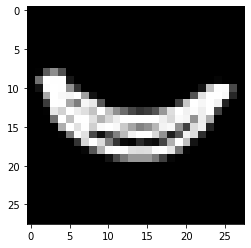

Selected sample of class:  banana


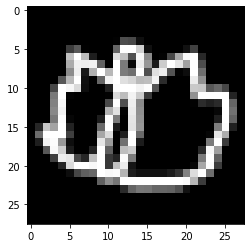

Selected sample of class:  bat


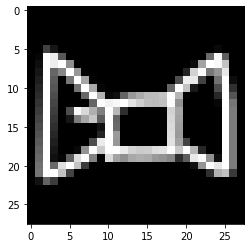

Selected sample of class:  bowtie


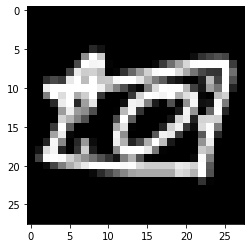

Selected sample of class:  camera


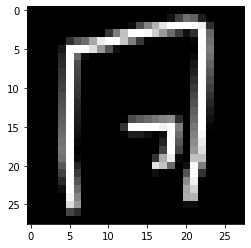

Selected sample of class:  door


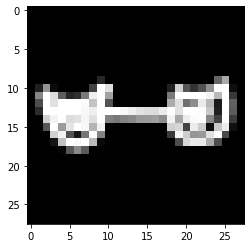

Selected sample of class:  eyeglasses


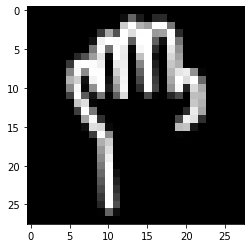

Selected sample of class:  hand


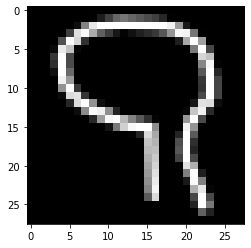

Selected sample of class:  mushroom


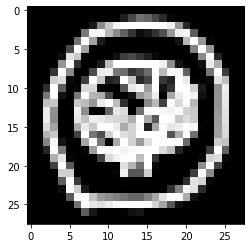

Selected sample of class:  wheel


In [7]:
for i in range(0, len(x_train_og), 8000):
  plt.imshow(x_train_og[i], cmap='gray')
  plt.show()
  print("Selected sample of class: ", classes[i//8000])

Here are some visual examples of the data. I picked image classes that are not too similar but share multiple features, such as round or rectangular shapes. Doors and cameras are both rectangular, while classes like wheels, cameras, and mushrooms have round visual features.

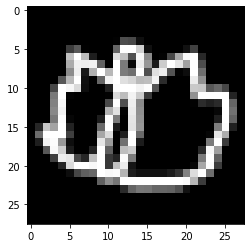

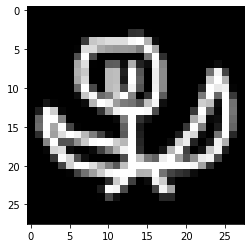

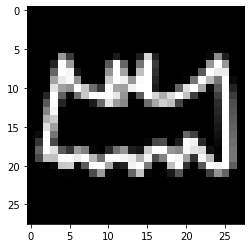

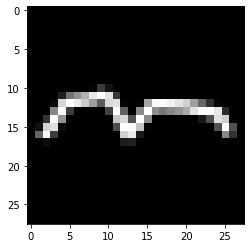

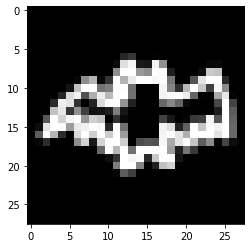

In [27]:
for i in range(8000, 8005):
  plt.imshow(x_train_og[i], cmap='gray')
  plt.show()

Here's some examples of bats. Out of all the classes, bats have the most varying samples - unlike the other classes, there are multiple ways for humans to identify bats, such as wing shape, or its symmetry.

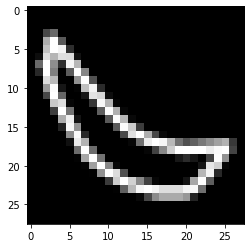

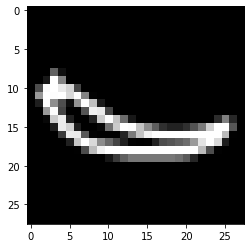

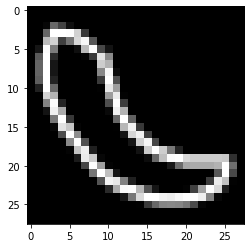

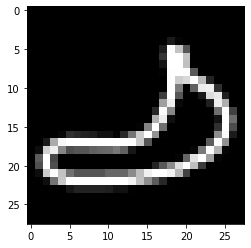

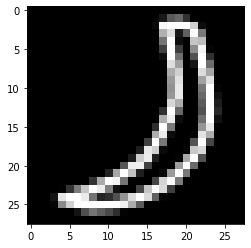

In [30]:
for i in range(2, 7):
  plt.imshow(x_train_og[i], cmap='gray')
  plt.show()

On the other hand, classes like banana have mostly uniform shapes, although their placements and directions vary. The models need to be able to find correlations from high dimensions and other techniques to successfully extract the common features.

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_og, y_train_og, stratify=y_train_og, train_size=5/6)
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test_og)

In [9]:
def plot_summary(history):
    fig, ax = plt.subplots(1,2, figsize=(15, 7))
    ax[0].set_title('Loss Graph')
    ax[0].plot(history.history['loss'], label='train loss')
    ax[0].plot(history.history['val_loss'], label='test/val loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].set_title('Accuracy Graph')
    ax[1].plot(history.history['Accuracy'], label='train accuracy')
    ax[1].plot(history.history['val_Accuracy'], label='test/val accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

In [10]:
def confusion_matrix(test, prediction):
    cm = metrics.confusion_matrix(test, prediction)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(7,5))
    sn.heatmap(cm_normalized, annot=True, annot_kws={"size": 8})
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    return cm_normalized

In [11]:
# model = svm.SVC(kernel='poly')
# x_train_flat = x_train_og.reshape((len(x_train_og), 784))
# x_test_flat = x_test.reshape((len(x_test), 784))
# model.fit(x_train_flat, y_train_og)
# print("score/accuracy: ", model.score(x_test_flat, y_test_og))

In [12]:
# prediction = model.predict(x_test_flat)
# confusion_matrix(y_test_og, prediction)

In regards to the above 2 code blocks, I had to run SVM with polynomial kernel on my local machine since Colab didn't like it and I had to waste $10 for 100 GPU units after getting locked out. Anyways, will attach confusion matrix below. The accuracy was not terrible, but it took forever (10+ minutes) for both training and predicting.

In [25]:
input = Input(shape=x_train[0].shape)
l1 = Flatten()(input)
l1 = Dense(128, activation='softplus')(l1)
l1 = Dense(64, activation='softplus')(l1)
output = Dense(9, activation='softmax')(l1)
model = Model(input, output)
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['Accuracy'])

Epoch 1/10
938/938 [==============================] - 4s 4ms/step - loss: 2.6184 - Accuracy: 0.5746 - val_loss: 1.1099 - val_Accuracy: 0.6915
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.8668 - Accuracy: 0.7459 - val_loss: 0.7881 - val_Accuracy: 0.7852
Epoch 3/10
938/938 [==============================] - 3s 4ms/step - loss: 0.6383 - Accuracy: 0.8095 - val_loss: 0.6484 - val_Accuracy: 0.8148
Epoch 4/10
938/938 [==============================] - 3s 4ms/step - loss: 0.5245 - Accuracy: 0.8461 - val_loss: 0.5955 - val_Accuracy: 0.8425
Epoch 5/10
938/938 [==============================] - 3s 4ms/step - loss: 0.4594 - Accuracy: 0.8635 - val_loss: 0.5226 - val_Accuracy: 0.8608
Epoch 6/10
938/938 [==============================] - 3s 4ms/step - loss: 0.4076 - Accuracy: 0.8782 - val_loss: 0.4774 - val_Accuracy: 0.8702
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.3805 - Accuracy: 0.8862 - val_loss: 0.4536 - val_Accuracy: 0.8765
Epoch 

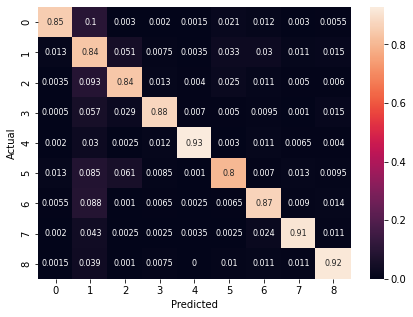

In [26]:
hist = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_valid, y_valid), verbose=1)
loss, acc = model.evaluate(x_test, y_test)
print("Final accuracy: ", acc)
print("Final loss: ", loss)
prediction = model.predict(x_test)
prediction = np.argmax(prediction, axis=1)
cm = confusion_matrix(y_test_og, prediction)

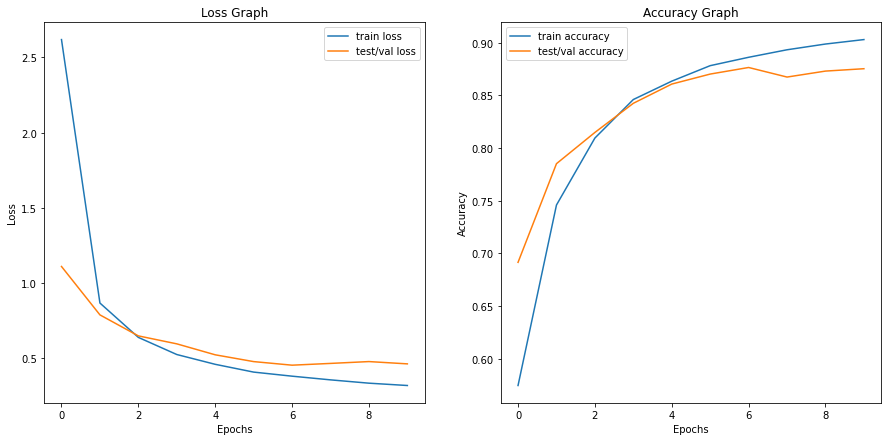

In [31]:
plot_summary(hist)

A regular artificial neural network with 2 layers performed ok. There may be room for better hyperparameters, which I may revisit in the future. The neural network can compute significantly faster than the SVM with GPU acceleration, however, a CNN could attempt to reduce the number of features through convolutional and max pooling layers.

In [13]:
# expand to accomodate channels for conv2d
x_train_cnn = np.expand_dims(x_train, 3)
x_valid_cnn = np.expand_dims(x_valid, 3)
x_test_cnn = np.expand_dims(x_test, 3)

In [15]:
#Model uses softplus activation function and 2 convolutional layers each followed by max pooling
input = Input(shape=x_train_cnn[0].shape)
l1 = input
l1 = Conv2D(64, kernel_size=(4,4), activation='softplus', padding='same')(l1)
l1 = MaxPooling2D((2, 2))(l1)
l1 = Conv2D(64, kernel_size=(4,4), activation='softplus', padding='same')(l1)
l1 = MaxPooling2D((2, 2))(l1)
l1 = Flatten()(l1)
output = Dense(9, activation='softmax')(l1)
model = Model(input, output)
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['Accuracy'])

Epoch 1/5
938/938 [==============================] - 13s 6ms/step - loss: 0.6941 - Accuracy: 0.8622 - val_loss: 0.3163 - val_Accuracy: 0.9123
Epoch 2/5
938/938 [==============================] - 5s 6ms/step - loss: 0.2770 - Accuracy: 0.9209 - val_loss: 0.2822 - val_Accuracy: 0.9232
Epoch 3/5
938/938 [==============================] - 6s 6ms/step - loss: 0.2348 - Accuracy: 0.9307 - val_loss: 0.2589 - val_Accuracy: 0.9259
Epoch 4/5
938/938 [==============================] - 5s 6ms/step - loss: 0.2198 - Accuracy: 0.9351 - val_loss: 0.2700 - val_Accuracy: 0.9237
Epoch 5/5
563/563 [==============================] - 2s 3ms/step - loss: 0.2715 - Accuracy: 0.9271
Final accuracy:  0.9270555377006531
Final loss:  0.2714568078517914
563/563 [==============================] - 1s 2ms/step


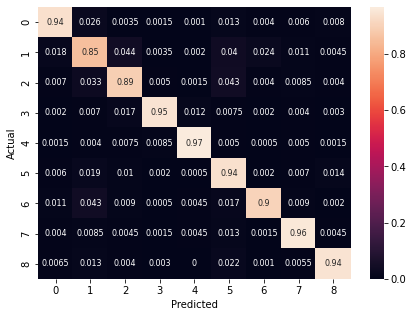

In [16]:
hist = model.fit(x_train_cnn, y_train, epochs=5, batch_size=64, validation_data=(x_valid_cnn, y_valid), verbose=1)
loss, acc = model.evaluate(x_test_cnn, y_test)
print("Final accuracy: ", acc)
print("Final loss: ", loss)
prediction = model.predict(x_test)
prediction = np.argmax(prediction, axis=1)
cm = confusion_matrix(y_test_og, prediction)

Since we also did CNN's for the previous assignment, I decided to borrow a configuration used for Fashion MNIST to test its performance here. The accuracy was decent, although the model had difficulty predicting class 1, bats (animal), which is likely due to overfitting.

In [17]:
es = EarlyStopping(monitor='val_loss',
                   verbose=1,
                   patience=7,
                   restore_best_weights=True)

In [141]:
input = Input(shape=x_train_cnn[0].shape)
l1 = input
l1 = Conv2D(64, kernel_size=(3,3), activation='softplus', padding='same')(l1)
l1 = MaxPooling2D((2, 2))(l1)
l1 = Conv2D(64, kernel_size=(3,3), activation='softplus', padding='same')(l1)
l1 = MaxPooling2D((2, 2))(l1)
l1 = Conv2D(64, kernel_size=(3,3), activation='softplus', padding='same')(l1)
l1 = MaxPooling2D((2, 2))(l1)
l1 = Dropout(0.75)(l1)
l1 = Flatten()(l1)
output = Dense(9, activation='softmax')(l1)
model = Model(input, output)
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['Accuracy'])

Epoch 1/20
938/938 [==============================] - 6s 6ms/step - loss: 1.1440 - Accuracy: 0.7034 - val_loss: 0.3747 - val_Accuracy: 0.8943
Epoch 2/20
938/938 [==============================] - 5s 6ms/step - loss: 0.4706 - Accuracy: 0.8631 - val_loss: 0.2917 - val_Accuracy: 0.9220
Epoch 3/20
938/938 [==============================] - 5s 6ms/step - loss: 0.3856 - Accuracy: 0.8881 - val_loss: 0.2722 - val_Accuracy: 0.9250
Epoch 4/20
938/938 [==============================] - 5s 6ms/step - loss: 0.3442 - Accuracy: 0.9008 - val_loss: 0.2368 - val_Accuracy: 0.9283
Epoch 5/20
938/938 [==============================] - 5s 5ms/step - loss: 0.3104 - Accuracy: 0.9097 - val_loss: 0.2376 - val_Accuracy: 0.9303
Epoch 6/20
938/938 [==============================] - 5s 6ms/step - loss: 0.2927 - Accuracy: 0.9151 - val_loss: 0.2131 - val_Accuracy: 0.9352
Epoch 7/20
938/938 [==============================] - 5s 6ms/step - loss: 0.2812 - Accuracy: 0.9180 - val_loss: 0.2137 - val_Accuracy: 0.9373
Epoch 

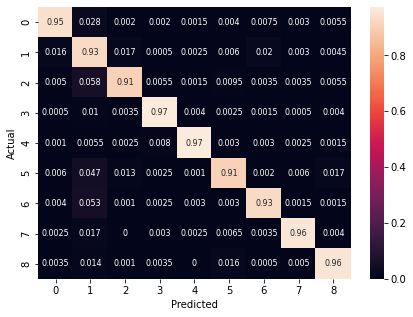

In [142]:
hist = model.fit(x_train_cnn, y_train, epochs=20, batch_size=64, validation_data=(x_valid_cnn, y_valid), verbose=1, callbacks=[es])
loss, acc = model.evaluate(x_test_cnn, y_test)
print("Final accuracy: ", acc)
print("Final loss: ", loss)
prediction = model.predict(x_test)
prediction = np.argmax(prediction, axis=1)
cm = confusion_matrix(y_test_og, prediction)

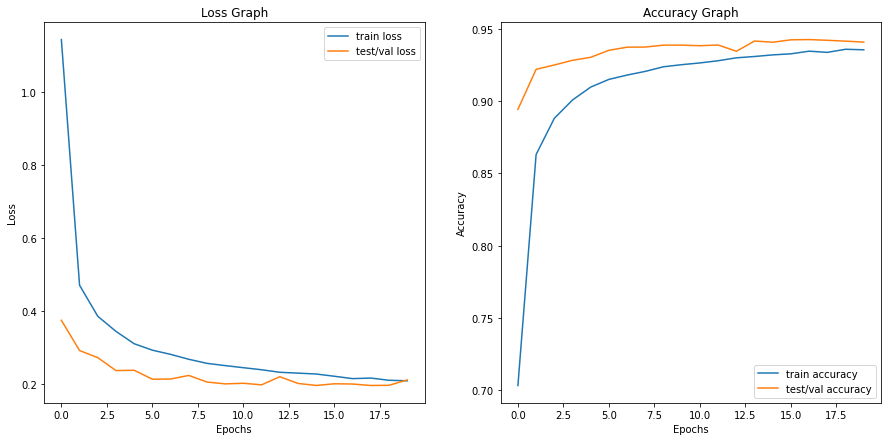

In [143]:
plot_summary(hist)

Before doing a random search, I decided to fix a couple of hyperparameters and regularizations that I believe are either optimal or a significant improvement from previous settings. I increased the convolutional layer count to 3, made the kernels 3x3, and added early stopping (with restorable memory) and a dropout layer; I tried adding dropout layers for the convolutions but they took too many epochs to train - I just added one for the last dense layer. Dropout helps to not overfit. As seen above, there's a good improvement in accuracy.

In [149]:
best_model = None
best_acc = None
best_loss = float("inf")
best_history = None

for i in range(20):

  n1 = np.random.randint(low=32, high=128)
  n2 = np.random.randint(low=32, high=128)
  n3 = np.random.randint(low=32, high=128)
  input = Input(shape=x_train_cnn[0].shape)
  l1 = input
  l1 = Conv2D(n1, kernel_size=(3,3), activation='softplus', padding='same')(l1)
  l1 = MaxPooling2D((2, 2))(l1)
  l1 = Conv2D(n2, kernel_size=(3,3), activation='softplus', padding='same')(l1)
  l1 = MaxPooling2D((2, 2))(l1)
  l1 = Conv2D(n3, kernel_size=(3,3), activation='softplus', padding='same')(l1)
  l1 = MaxPooling2D((2, 2))(l1)
  l1 = Dropout(0.75)(l1)
  l1 = Flatten()(l1)
  output = Dense(9, activation='softmax')(l1)
  model = Model(input, output)
  model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['Accuracy'])

  hist = model.fit(x_train_cnn, y_train, epochs=25, batch_size=64, validation_data=(x_valid_cnn, y_valid), verbose=0, callbacks=[es])
  loss, acc = model.evaluate(x_test_cnn, y_test)
  print("Num of layers: ", n1, ", ", n2, ", ", n3, ", Final accuracy: ", acc, ", Final loss: ", loss)
  if loss < best_loss:
    best_model = model
    best_loss = loss
    best_acc = acc
    best_history = hist
  

563/563 [==============================] - 2s 3ms/step - loss: 0.1896 - Accuracy: 0.9438
Num of layers:  85 ,  74 ,  55 , Final accuracy:  0.9437777996063232 , Final loss:  0.18956170976161957
563/563 [==============================] - 2s 3ms/step - loss: 0.1905 - Accuracy: 0.9447
Num of layers:  82 ,  109 ,  53 , Final accuracy:  0.9446666836738586 , Final loss:  0.19054515659809113
563/563 [==============================] - 2s 3ms/step - loss: 0.1888 - Accuracy: 0.9482
Num of layers:  112 ,  91 ,  75 , Final accuracy:  0.9482222199440002 , Final loss:  0.18877984583377838
Restoring model weights from the end of the best epoch: 14.
Epoch 21: early stopping
563/563 [==============================] - 2s 4ms/step - loss: 0.1938 - Accuracy: 0.9415
Num of layers:  99 ,  81 ,  37 , Final accuracy:  0.9415000081062317 , Final loss:  0.1937868446111679
Restoring model weights from the end of the best epoch: 16.
Epoch 23: early stopping
563/563 [==============================] - 2s 4ms/step - 

Best accuracy:  0.9472777843475342
Best loss:  0.17193017899990082
563/563 [==============================] - 1s 2ms/step


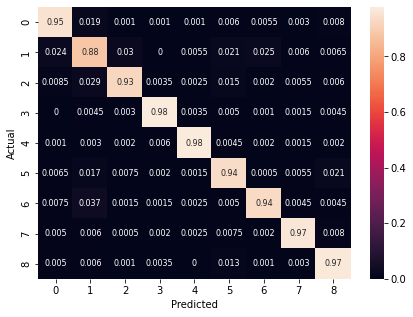

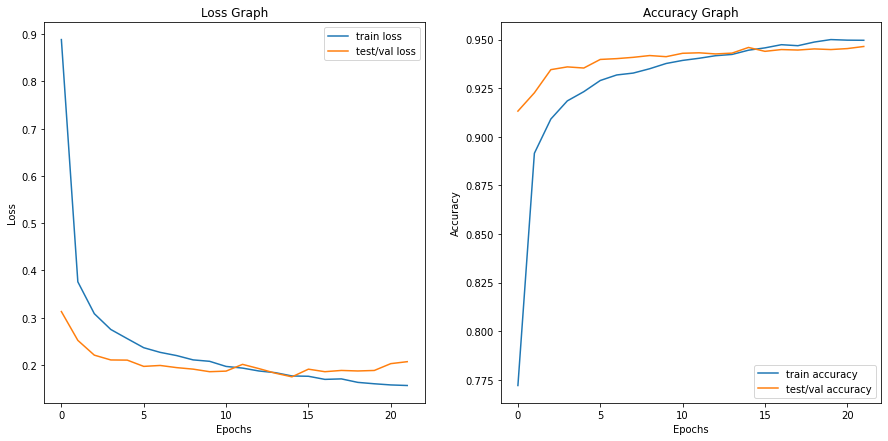

In [154]:
print("Best accuracy: ", best_acc)
print("Best loss: ", best_loss)
prediction = best_model.predict(x_test)
prediction = np.argmax(prediction, axis=1)
cm = confusion_matrix(y_test_og, prediction)
plot_summary(best_history)

The model with the lowest loss from doing random search on 3 hyperparameters, namely the number of neurons per convolutional layer, performed very well, at an accuracy of 94.7%. It didn't have the best accuracy out of all models tested in the validation search, however there is some randomness involved, and upon further training with the optimal model and those with better validation accuracies, it seems that the long term winner is still the one with the lowest loss. A lower accuracy with a low loss may be due to having numerous small errors.

Overall, most models had trouble predicting bats, as expected from my pre-training analysis. Interestingly, the model I tuned before doing random search (specifically, the CNN with regularization and 64x3 c.neurons) had a decent accuracy on bats at the slight cost of predicting a few other classes. CNN's are better than the polynomial kernel SVM, which is better than the untuned 2 hidden layer ANN. Regularization had a significant role in improving the CNN. I think it's possible to include different dropout rates, add/drop other regularization methods, and tune other hyperparameters in random/grid search if I had more time and compute power, however I am pretty happy with the result. Perhaps it would also be interesting to see how the CNN performs when trained on classes that are visually similar, e.g. circles vs. clocks, or birds vs. flamingos.